In [1]:
import os
import re
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import random
import pickle
import cv2

from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
random.seed(1)
path = '/Users/clarysaaa/Desktop/LSE/LT ma429 machine learning/summative/Images'
folders = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]

In [3]:
data = []

In [4]:
# Define the target dimensions
target_width = 50
target_height = 50

# Iterate through the folders
for folder in folders:
    # Label as healthy or diseased
    if folder.endswith('healthy'):
        label = 1
    else:
        label = 0
    
    # Iterate through the images in the folder
    for image_name in os.listdir(os.path.join(path, folder)):
        # Get the image path
        image_path = os.path.join(path, folder, image_name)
        
        # Read the image using cv2
        img = cv2.imread(image_path)
        
        # Convert the image to grayscale
        bw_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Resize the image to the target dimensions
        resized_img = cv2.resize(bw_img, (target_width, target_height))
        
        # Convert image to pixel values
        pixel_values = np.array(resized_img)
        
        # Add image and label to the dataset
        data.append((pixel_values, label))

In [5]:
data = data[:10000]

In [6]:
# Shuffle the data
random.shuffle(data)

In [7]:
images = [pair[0] for pair in data]
labels = [pair[1] for pair in data]

In [8]:
# Define the proportions for train, validation, and test sets
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

In [9]:
# Calculate the number of samples for each set
num_samples = len(data)
num_train = int(train_ratio * num_samples)
num_val = int(val_ratio * num_samples)
num_test = num_samples - num_train - num_val

In [10]:
# Split the data
train_images = images[:num_train]
val_images = images[num_train:num_train + num_val]
test_images = images[num_train + num_val:]

# Split the data
train_labels = labels[:num_train]
val_labels = labels[num_train:num_train + num_val]
test_labels = labels[num_train + num_val:]

In [11]:
def normalise_images(images):
    
    mean = np.mean(images, axis=0)
    print(mean)
    variance = np.var(images, axis=0)
    
    return mean, variance

In [12]:
mean, var = normalise_images(train_images)

[[128.6395     129.28366667 130.37716667 ... 130.15766667 129.269
  128.4015    ]
 [129.29633333 130.1035     130.81133333 ... 130.24033333 129.56633333
  128.85533333]
 [129.89166667 130.44683333 130.95433333 ... 130.33966667 129.66333333
  129.30033333]
 ...
 [127.756      128.05983333 128.13766667 ... 127.82233333 127.61466667
  127.3485    ]
 [127.28783333 127.517      127.648      ... 127.4415     127.583
  127.25333333]
 [126.45733333 127.27583333 127.6525     ... 127.18683333 126.93583333
  126.467     ]]


In [13]:
def apply_normalisation(images, mean, variance):
    
    images = (images - mean) / np.sqrt(variance)
    
    return images

In [14]:
# Normalize the data, Gaussian distribution
train_images = apply_normalisation(train_images, mean, var)
val_images = apply_normalisation(val_images, mean, var)
test_images = apply_normalisation(test_images, mean, var)

In [15]:
img = train_images[2]

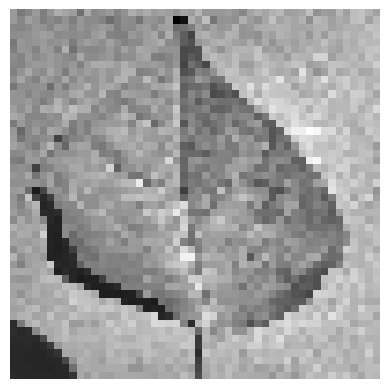

In [16]:
# Display the image
plt.imshow(img, cmap='gray')
plt.axis('off')  # Hide axis
plt.show()

In [17]:
# Convert lists to numpy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)

# Flatten the input images
train_images = train_images.reshape(len(train_images), -1)
val_images = val_images.reshape(len(val_images), -1)
test_images = test_images.reshape(len(test_images), -1)

In [18]:
# Specify the desired explained variance
desired_variance = 0.85

# Fit PCA with the desired explained variance
pca = PCA(n_components=desired_variance, svd_solver='full')
train_images_reduced = pca.fit_transform(train_images)

# Get the actual explained variance ratio
actual_variance = np.sum(pca.explained_variance_ratio_)

# Get the number of components used
num_components = pca.n_components_

# Print the actual explained variance and the number of components used
print(f"Actual explained variance: {actual_variance}")
print(f"Number of components used: {num_components}")

Actual explained variance: 0.8501479747876528
Number of components used: 155


Explained Variance Ratio by Component: [0.23597321 0.11352688 0.07299246 0.05735629 0.0416268  0.02736372
 0.01948472 0.01822155 0.01429165 0.01344934 0.01095508 0.00992721
 0.00837119 0.00794855 0.00776177 0.00697763 0.00638672 0.00570317
 0.0051866  0.00504402 0.00494152 0.00479316 0.00423512 0.00406608
 0.00400643 0.00353698 0.00348107 0.00340838 0.00317691 0.00299295
 0.00290413 0.0028288  0.00269749 0.00267023 0.00250987 0.00243964
 0.00233448 0.00224531 0.00219977 0.00213128 0.00206747 0.00200975
 0.00190523 0.00187492 0.0018451  0.00179006 0.00176242 0.00169442
 0.0016777  0.00164698 0.00161419 0.0015469  0.00147381 0.00146156
 0.00143379 0.00141694 0.00135872 0.00132359 0.00129497 0.00127606
 0.00125342 0.00124673 0.00121389 0.0011976  0.00116042 0.00114574
 0.00113851 0.00109622 0.001074   0.0010724  0.00105684 0.00103007
 0.00101562 0.00099982 0.00098973 0.00098568 0.00097719 0.0009547
 0.00093439 0.00090571 0.0008939  0.00088488 0.00085781 0.00084257
 0.00083473 0.00082392 0

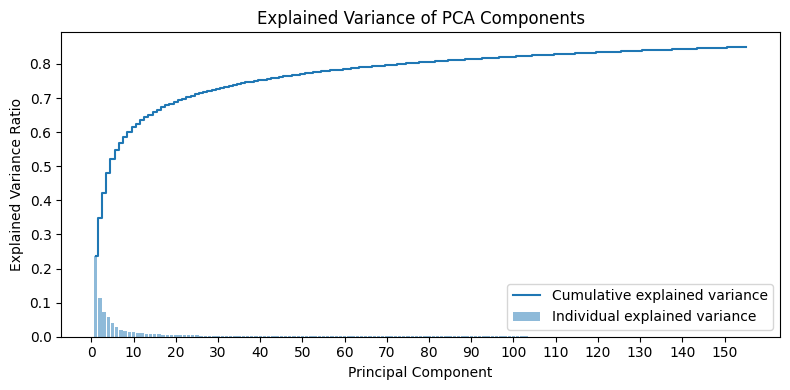

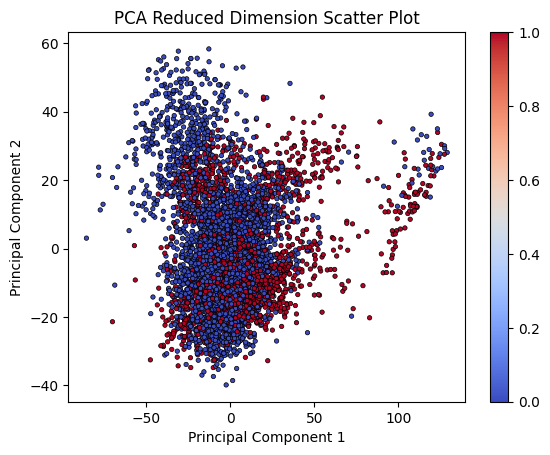

In [19]:
# Explained variance ratio for each principal component
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Print detailed PCA report
print("Explained Variance Ratio by Component:", explained_variance)
print("Cumulative Explained Variance:", cumulative_variance)

# Determine the number of principal components
num_components = len(explained_variance)

# Generate ticks at positions 1, 10, 20, 30, etc., up to num_components
ticks = np.arange(0, num_components + 1, 10)

# Plot the explained variance
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.title('Explained Variance of PCA Components')
plt.xticks(ticks)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Plot data points in reduced space with decision boundary visualization (if needed)
plt.figure()
plt.scatter(train_images_reduced[:, 0], train_images_reduced[:, 1], c=train_labels, cmap=plt.cm.coolwarm, edgecolors='k', linewidths=0.5, s=10)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Reduced Dimension Scatter Plot')
plt.colorbar()
plt.show()

In [ ]:
# Apply the same PCA transformation to the validation and test sets
val_images_reduced = pca.transform(val_images)
test_images_reduced = pca.transform(test_images)

# Define a range of C values to iterate over
C_values = [0.01, 0.1, 1, 3, 5, 10]

# Initialize lists to store results
C_values_list = []
validation_accuracy_list = []
test_accuracy_list = []

# Initialize a dictionary to store trained models
trained_models = {}

# Iterate over each C value
for C in C_values:
    # Create SVM classifier with linear kernel and specified C value
    clf_linear = svm.SVC(kernel='linear', C=C)
    
    # Fit the classifier to the training data
    clf_linear.fit(train_images_reduced, train_labels)
    
    # Make predictions on the validation data
    val_pred = clf_linear.predict(val_images_reduced)
    
    # Calculate the accuracy of the classifier on validation set
    val_accuracy = accuracy_score(val_labels, val_pred)
    
    # Store the accuracy in the lists
    C_values_list.append(C)
    validation_accuracy_list.append(val_accuracy)

    # Store the trained model
    trained_models[C] = clf_linear

    print(f"Accuracy for C={C} on validation set: {val_accuracy}")

# Find the index of the maximum validation accuracy
best_index = validation_accuracy_list.index(max(validation_accuracy_list))

# Retrieve the best C value
best_C = C_values_list[best_index]
print(f"Best C value based on validation set: {best_C}")

# Retrieve the best model
best_clf_linear = trained_models[best_C]

# Make predictions on the test set
test_pred = best_clf_linear.predict(test_images_reduced)

# Calculate the accuracy of the best classifier on the test set
test_accuracy = accuracy_score(test_labels, test_pred)
print(f"Accuracy for the best model on the test set: {test_accuracy}")

# Save all trained models to files using pickle
for C, clf in trained_models.items():
    model_filename = f"svm_model_linear_C_{C}.pickle"
    with open(model_filename, 'wb') as file:
        pickle.dump(clf, file)
    print(f"Model with C={C} saved as {model_filename}")

Accuracy for C=0.01 on validation set: 0.7485
Accuracy for C=0.1 on validation set: 0.751
Accuracy for C=1 on validation set: 0.7505
Accuracy for C=3 on validation set: 0.751
Accuracy for C=5 on validation set: 0.7505


In [22]:
# Define a range of C, gamma, and degrees for RBF kernel
C_values = [0.01, 0.1, 1, 3, 5, 10]
gamma_values = [0.01, 0.1, 1]

# Define a range of C, gamma, and degrees for polynomial kernel
degrees = [2, 3, 4, 5]

# Initialize dictionaries to store accuracies
accuracy_dict_rbf = {}
accuracy_dict_poly = {}

# Initialize dictionaries to store trained models
trained_models_rbf = {}
trained_models_poly = {}

# Iterate over each C value for RBF kernel
for C in C_values:
    for gamma in gamma_values:
        # Create SVM classifier with RBF kernel, specified C and gamma
        clf_rbf = svm.SVC(kernel='rbf', C=C, gamma=gamma)
        clf_rbf.fit(train_images_reduced, train_labels)

        # Make predictions on the validation data and calculate accuracy
        val_pred_rbf = clf_rbf.predict(val_images_reduced)
        val_accuracy_rbf = accuracy_score(val_labels, val_pred_rbf)
        accuracy_dict_rbf[(C, gamma)] = val_accuracy_rbf

        # Store the trained model
        trained_models_rbf[(C, gamma)] = clf_rbf

        print(f"RBF Model with C={C}, gamma={gamma} trained. Validation Accuracy: {val_accuracy_rbf}")

# Iterate over each C, gamma, and degree for polynomial kernel
for C in C_values:
    for gamma in gamma_values:
        for degree in degrees:
            # Create SVM classifier with polynomial kernel, specified C, gamma, and degree
            clf_poly = svm.SVC(kernel='poly', C=C, gamma=gamma, degree=degree)
            clf_poly.fit(train_images_reduced, train_labels)

            # Make predictions on the validation data and calculate accuracy
            val_pred_poly = clf_poly.predict(val_images_reduced)
            val_accuracy_poly = accuracy_score(val_labels, val_pred_poly)
            accuracy_dict_poly[(C, gamma, degree)] = val_accuracy_poly

            # Store the trained model
            trained_models_poly[(C, gamma, degree)] = clf_poly

            print(f"Poly Model with C={C}, gamma={gamma}, degree={degree} trained. Validation Accuracy: {val_accuracy_poly}")

# Find the best models based on validation accuracy
best_params_rbf = max(accuracy_dict_rbf, key=accuracy_dict_rbf.get)
best_params_poly = max(accuracy_dict_poly, key=accuracy_dict_poly.get)

# Retrieve the best models
best_clf_rbf = trained_models_rbf[best_params_rbf]
best_clf_poly = trained_models_poly[best_params_poly]

# Make predictions on the test set for the best models
test_pred_rbf = best_clf_rbf.predict(test_images_reduced)
test_pred_poly = best_clf_poly.predict(test_images_reduced)

# Calculate accuracies on the test set
test_accuracy_rbf = accuracy_score(test_labels, test_pred_rbf)
test_accuracy_poly = accuracy_score(test_labels, test_pred_poly)

# Print the results
print(f"Best RBF Model parameters: C={best_params_rbf[0]}, gamma={best_params_rbf[1]}")
print(f"Test Accuracy for the best RBF Model: {test_accuracy_rbf}")

print(f"Best Poly Model parameters: C={best_params_poly[0]}, gamma={best_params_poly[1]}, degree={best_params_poly[2]}")
print(f"Test Accuracy for the best Poly Model: {test_accuracy_poly}")

# Save the best models to files using pickle
model_filename_rbf = f"svm_model_rbf_best_C_{best_params_rbf[0]}_gamma_{best_params_rbf[1]}.pickle"
model_filename_poly = f"svm_model_poly_best_C_{best_params_poly[0]}_gamma_{best_params_poly[1]}_degree_{best_params_poly[2]}.pickle"

with open(model_filename_rbf, 'wb') as file:
    pickle.dump(best_clf_rbf, file)
    
with open(model_filename_poly, 'wb') as file:
    pickle.dump(best_clf_poly, file)

print(f"Best RBF Model saved as: {model_filename_rbf}")
print(f"Best Poly Model saved as: {model_filename_poly}")

# Create a table of results for RBF kernel
results_rbf = pd.DataFrame(list(accuracy_dict_rbf.items()), columns=['(C, gamma)', 'Validation Accuracy'])
print("Results for RBF Kernel:")
print(results_rbf)

# Create a table of results for polynomial kernel
results_poly = pd.DataFrame(list(accuracy_dict_poly.items()), columns=['(C, gamma, degree)', 'Validation Accuracy'])
print("Results for Polynomial Kernel:")
print(results_poly)

RBF Model with C=0.01, gamma=0.01 trained. Validation Accuracy: 0.6725
RBF Model with C=0.01, gamma=0.1 trained. Validation Accuracy: 0.6725
RBF Model with C=0.01, gamma=1 trained. Validation Accuracy: 0.6725
RBF Model with C=0.1, gamma=0.01 trained. Validation Accuracy: 0.6725
RBF Model with C=0.1, gamma=0.1 trained. Validation Accuracy: 0.6725
RBF Model with C=0.1, gamma=1 trained. Validation Accuracy: 0.6725
RBF Model with C=1, gamma=0.01 trained. Validation Accuracy: 0.674
RBF Model with C=1, gamma=0.1 trained. Validation Accuracy: 0.6725
RBF Model with C=1, gamma=1 trained. Validation Accuracy: 0.6725
RBF Model with C=3, gamma=0.01 trained. Validation Accuracy: 0.6785
RBF Model with C=3, gamma=0.1 trained. Validation Accuracy: 0.6725
RBF Model with C=3, gamma=1 trained. Validation Accuracy: 0.6725
RBF Model with C=5, gamma=0.01 trained. Validation Accuracy: 0.6785
RBF Model with C=5, gamma=0.1 trained. Validation Accuracy: 0.6725
RBF Model with C=5, gamma=1 trained. Validation Acc

In [23]:
results_poly

,"(C, gamma, degree)",Validation Accuracy
0,"(0.01, 0.01, 2)",0.7485
1,"(0.01, 0.01, 3)",0.7965
2,"(0.01, 0.01, 4)",0.7520
3,"(0.01, 0.01, 5)",0.7490
4,"(0.01, 0.1, 2)",0.7145
...,...,...
67,"(10, 0.1, 5)",0.7490
68,"(10, 1, 2)",0.7075
69,"(10, 1, 3)",0.7710
70,"(10, 1, 4)",0.7480
